# Statistical Tests

We wish to check whether the LST and NDVI between HOLC grades is significantly different. To do this we apply Student's t-test, which is designed to determine the statistical difference between two sets of data. 

Our input data consists of LST and NDVI computed in year ranges of approximately 10 years for HOLC grades A through D. We make two types of comparisons:

1. Intrayear: two datasets from the same decade between different grades 
2. Intragrade: two datasets containing statistics for the same grade and between different decade

The test compares against the null hypothesis, which states that there is no difference between the means. If the calculated t-value is greater than the t-value from the t-table for the desired alpha level, then the null hypothesis can be rejected. This implies that the differences between the populations did not happen by chance. 

We apply the independent T-Test. Assumptions of the test:

1. The data is normally distributed. (This assumption holds for LST but fails for NDVI.)
2. The population variance in unknown, and the sample variances are approximately equal. *Scipy's t-test function has an option for computing the t-statistic with two datasets with unequal variance. This is done by specifying `equal_var=False`. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for details.*
3. The data leading to each mean are independent. *(There's no overlap in HOLC boundaries, so I think this holds.)*

## Data 

Data is imported from `02-data/summary_stats_temporal`. This folder contains results from aggregating statistics in `4_compute_summary_stats.ipynb`. In Method 4 of that notebook, these statistics were aggregated temporally by collecting every statistic within a decade into one large file named "/m4_ext_**OBS**_pfilt**PFILT**_yr**YR**.csv", where **OBS** = "lst" or "ndvi", **PFILT** is a float between 0.0 and 1.0 representing the cloud filtering threshold, and **YR** is an integer between 0 and 3 refering to the decade. Using this data, we collect all of the median values for some HOLC grade and test whether the mean values of those are statistically significant. 

In [24]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push directory to helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)
import helpers

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_DATA = DIR_PARENT + "/02-data"
DIR_STATS_T = DIR_DATA + "/summary_stats_temporal"

def get_dof(df_yrA, df_yrB, grade1, grade2, stat_choice="median"):
    return len(df_yrA[(df_yrA["holc_grade"]==grade1)][stat_choice].dropna())+\
       len(df_yrB[(df_yrB["holc_grade"]==grade2)][stat_choice].dropna())-2

### Import data

In [30]:
## USER INPUTS ##################################################################
obs = "lst" # OPTIONS: "lst" or "ndvi"
pfilt = 0.0 # OPTIONS: 0.0 or 0.9
## END USER INPUTS ##############################################################

df_yr0 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+obs+"_pfilt"+str(pfilt)+"_yr0.csv")
df_yr1 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+obs+"_pfilt"+str(pfilt)+"_yr1.csv")
df_yr2 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+obs+"_pfilt"+str(pfilt)+"_yr2.csv")
df_yr3 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+obs+"_pfilt"+str(pfilt)+"_yr3.csv")

## 1. Test Assumptions of T-test <a id="assumptions"></a>

### Assumption 1: Test Normal Distribution

Mean LST =  299.5480358906281
Stdev LST =  3.133421378833548


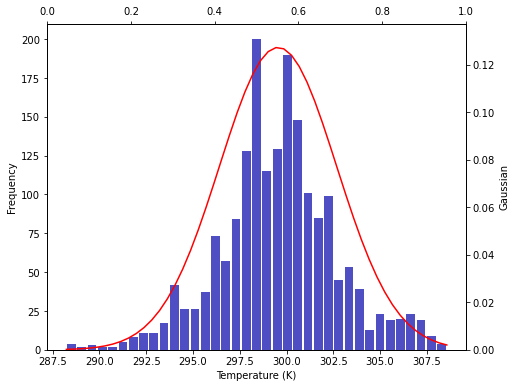

In [46]:
data_choice = df_yr1 # OPTIONS: df_yr0, df_yr1, df_yr2, df_yr3
holc_choice = "B" # OPTIONS: A, B, C, D
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

#########################################################################
data_to_test = data_choice[data_choice["holc_grade"]==
                               holc_choice][stat_choice]

fig, ax = plt.subplots(1,1, figsize=(7.5,6))

ax2 = ax.twinx()
ax3 = ax.twiny()

ax.hist(x=data_to_test, bins='auto', 
        color='#0504aa', alpha=0.7, rwidth=0.85)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Frequency")

"""Make Gasssian plot"""
avg_data = np.mean(data_to_test)
std_data = np.std(data_to_test)
xgauss = np.linspace(np.min(data_to_test),np.max(data_to_test),50)
ygauss = [(1/(std_data*np.sqrt(2*np.pi)))*np.exp(
            -(x-avg_data)**2/(2*std_data**2)) for x in xgauss]

"""Set the limits of the gaussian plot"""
ax2.set_ylim(ax2.get_ybound()[0], (1/(std_data*np.sqrt(2*np.pi)))+0.01)

ax2.plot(xgauss, ygauss, c="r")
ax2.set_ylabel("Gaussian")

print("Mean LST = ", avg_data)
print("Stdev LST = ", std_data)

## Assumption 2: Equal Variances

Calculating the variance of each data set, we indeed find that they're about the same within one year, but they are not the same in between years. 

In [25]:
lst_stats = df_yr3 # OPTIONS: df_yr0, df_yr1, df_yr2, df_yr3
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

######################################################################
lst_a = lst_stats[(lst_stats["holc_grade"]=="A")][stat_choice]
lst_b = lst_stats[(lst_stats["holc_grade"]=="B")][stat_choice]
lst_c = lst_stats[(lst_stats["holc_grade"]=="C")][stat_choice]
lst_d = lst_stats[(lst_stats["holc_grade"]=="D")][stat_choice]

print("Variance of HOLC A = ", np.var(lst_a))
print("Variance of HOLC B = ", np.var(lst_b))
print("Variance of HOLC C = ", np.var(lst_c))
print("Variance of HOLC D = ", np.var(lst_d))

Variance of HOLC A =  11.71145587387016
Variance of HOLC B =  11.328006814289617
Variance of HOLC C =  11.199756592172797
Variance of HOLC D =  12.863806564423387


## 2. Intrayear t-test

Below we compute the t-values between pairs of HOLC grades. In this way, we test for independence of means between HOLC A and HOLC B, HOLC A and HOLC C, etc. 

We use `scipy`'s `ttest_ind` function. The [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) gives the following description of this function. 

    Calculate the T-test for the means of two independent samples of scores.

    This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.
    
This can be avoided by setting the parameter `equal_var=False`.

In [26]:
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

############################################################################
def intrayear_tstat(df_yr, holc1, holc2, stat_choice="median"):
    """
    Compute the intra-year t-statistic. This means that the statistiic
    is computed between means of the same year range and different grades.
    """
    return stats.ttest_ind(
            df_yr[(df_yr["holc_grade"]==holc1)][stat_choice].dropna(), 
            df_yr[(df_yr["holc_grade"]==holc2)][stat_choice].dropna(), 
            equal_var=False)

stat_df = pd.DataFrame(columns=["t-value","p-value"],
                      index=["yr0a_yr0b"])

stat_df.loc["yr0a_yr0b"] = intrayear_tstat(df_yr0, "A", "B")
stat_df.loc["yr0a_yr0c"] = intrayear_tstat(df_yr0, "A", "C")
stat_df.loc["yr0a_yr0d"] = intrayear_tstat(df_yr0, "A", "D")
stat_df.loc["yr0b_yr0c"] = intrayear_tstat(df_yr0, "B", "C")
stat_df.loc["yr0b_yr0d"] = intrayear_tstat(df_yr0, "B", "D")
stat_df.loc["yr0c_yr0d"] = intrayear_tstat(df_yr0, "C", "D")

stat_df.loc["yr1a_yr1b"] = intrayear_tstat(df_yr1, "A", "B")
stat_df.loc["yr1a_yr1c"] = intrayear_tstat(df_yr1, "A", "C")
stat_df.loc["yr1a_yr1d"] = intrayear_tstat(df_yr1, "A", "D")
stat_df.loc["yr1b_yr1c"] = intrayear_tstat(df_yr1, "B", "C")
stat_df.loc["yr1b_yr1d"] = intrayear_tstat(df_yr1, "B", "D")
stat_df.loc["yr1c_yr1d"] = intrayear_tstat(df_yr1, "C", "D")

stat_df.loc["yr2a_yr2b"] = intrayear_tstat(df_yr2, "A", "B")
stat_df.loc["yr2a_yr2c"] = intrayear_tstat(df_yr2, "A", "C")
stat_df.loc["yr2a_yr2d"] = intrayear_tstat(df_yr2, "A", "D")
stat_df.loc["yr2b_yr2c"] = intrayear_tstat(df_yr2, "B", "C")
stat_df.loc["yr2b_yr2d"] = intrayear_tstat(df_yr2, "B", "D")
stat_df.loc["yr2c_yr2d"] = intrayear_tstat(df_yr2, "C", "D")

stat_df.loc["yr3a_yr3b"] = intrayear_tstat(df_yr3, "A", "B")
stat_df.loc["yr3a_yr3c"] = intrayear_tstat(df_yr3, "A", "C")
stat_df.loc["yr3a_yr3d"] = intrayear_tstat(df_yr3, "A", "D")
stat_df.loc["yr3b_yr3c"] = intrayear_tstat(df_yr3, "B", "C")
stat_df.loc["yr3b_yr3d"] = intrayear_tstat(df_yr3, "B", "D")
stat_df.loc["yr3c_yr3d"] = intrayear_tstat(df_yr3, "C", "D")


"""Add a column for the degrees of freedom"""
dof = [get_dof(df_yr0, df_yr0, "A", "B"),
       get_dof(df_yr0, df_yr0, "A", "C"),
       get_dof(df_yr0, df_yr0, "A", "D"),
       get_dof(df_yr0, df_yr0, "B", "C"),
       get_dof(df_yr0, df_yr0, "B", "D"),
       get_dof(df_yr0, df_yr0, "C", "D"),
       
       get_dof(df_yr1, df_yr1, "A", "B"),
       get_dof(df_yr1, df_yr1, "A", "C"),
       get_dof(df_yr1, df_yr1, "A", "D"),
       get_dof(df_yr1, df_yr1, "B", "C"),
       get_dof(df_yr1, df_yr1, "B", "D"),
       get_dof(df_yr1, df_yr1, "C", "D"),
       
       get_dof(df_yr2, df_yr2, "A", "B"),
       get_dof(df_yr2, df_yr2, "A", "C"),
       get_dof(df_yr2, df_yr2, "A", "D"),
       get_dof(df_yr2, df_yr2, "B", "C"),
       get_dof(df_yr2, df_yr2, "B", "D"),
       get_dof(df_yr2, df_yr2, "C", "D"),
       
       get_dof(df_yr3, df_yr3, "A", "B"),
       get_dof(df_yr3, df_yr3, "A", "C"),
       get_dof(df_yr3, df_yr3, "A", "D"),
       get_dof(df_yr3, df_yr3, "B", "C"),
       get_dof(df_yr3, df_yr3, "B", "D"),
       get_dof(df_yr3, df_yr3, "C", "D")]
stat_df["dof"] = dof

# Print the table
stat_df 

,t-value,p-value,dof
yr0a_yr0b,-7.30086,8.67596e-13,2286
yr0a_yr0c,-11.0092,2.17744e-25,5320
yr0a_yr0d,-10.6272,3.8554e-24,3502
yr0b_yr0c,-5.87845,4.52938e-09,6776
yr0b_yr0d,-5.25824,1.52864e-07,4958
yr0c_yr0d,0.186001,0.85245,7992
yr1a_yr1b,-8.86832,8.0172e-18,2286
yr1a_yr1c,-15.1142,1.35378e-42,5315
yr1a_yr1d,-15.1998,1.0011e-43,3500
yr1b_yr1c,-10.6809,3.29038e-26,6771


## 3. Intragrade t-test

Below we compute the t-values between different years for the same HOLC grade. In this way, we test whether there is a statistically significant difference in LST or NDVI across different decades within the same grade. 

In [29]:
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

############################################################################

stat_df = pd.DataFrame(columns=["t-value","p-value"],
                      index=["yr0a_yr1a"])

def intragrade_tstat(df1, df2, holc):
    """
    Compute the intra-grade t-statistic. This means that the statistiic
    is computed between means of the same grade and different year
    ranges.
    """
    return stats.ttest_ind(
            df1[(df1["holc_grade"]==holc)][stat_choice].dropna(), 
            df2[(df2["holc_grade"]==holc)][stat_choice].dropna(), 
            equal_var=False)

stat_df.loc["yr0a_yr1a"] = intragrade_tstat(df_yr0, df_yr1, "A")
stat_df.loc["yr0a_yr2a"] = intragrade_tstat(df_yr0, df_yr2, "A")
stat_df.loc["yr0a_yr3a"] = intragrade_tstat(df_yr0, df_yr3, "A")

stat_df.loc["yr0b_yr1b"] = intragrade_tstat(df_yr0, df_yr1, "B")
stat_df.loc["yr0b_yr2b"] = intragrade_tstat(df_yr0, df_yr2, "B")
stat_df.loc["yr0b_yr3b"] = intragrade_tstat(df_yr0, df_yr3, "B")

stat_df.loc["yr0c_yr1c"] = intragrade_tstat(df_yr0, df_yr1, "C")
stat_df.loc["yr0c_yr2c"] = intragrade_tstat(df_yr0, df_yr2, "C")
stat_df.loc["yr0c_yr3c"] = intragrade_tstat(df_yr0, df_yr3, "C")

stat_df.loc["yr0d_yr1d"] = intragrade_tstat(df_yr0, df_yr1, "D")
stat_df.loc["yr0d_yr2d"] = intragrade_tstat(df_yr0, df_yr2, "D")
stat_df.loc["yr0d_yr3d"] = intragrade_tstat(df_yr0, df_yr3, "D")

stat_df.loc["yr1a_yr2a"] = intragrade_tstat(df_yr1, df_yr2, "A")
stat_df.loc["yr1a_yr3a"] = intragrade_tstat(df_yr1, df_yr3, "A")

stat_df.loc["yr1b_yr2b"] = intragrade_tstat(df_yr1, df_yr2, "B")
stat_df.loc["yr1b_yr3b"] = intragrade_tstat(df_yr1, df_yr3, "B")

stat_df.loc["yr1c_yr2c"] = intragrade_tstat(df_yr1, df_yr2, "C")
stat_df.loc["yr1c_yr3c"] = intragrade_tstat(df_yr1, df_yr3, "C")

stat_df.loc["yr1d_yr2d"] = intragrade_tstat(df_yr1, df_yr2, "D")
stat_df.loc["yr1d_yr3d"] = intragrade_tstat(df_yr1, df_yr3, "D")

stat_df.loc["yr2a_yr3a"] = intragrade_tstat(df_yr2, df_yr3, "A")

stat_df.loc["yr2b_yr3b"] = intragrade_tstat(df_yr2, df_yr3, "B")

stat_df.loc["yr2c_yr3c"] = intragrade_tstat(df_yr2, df_yr3, "C")

stat_df.loc["yr2d_yr3d"] = intragrade_tstat(df_yr2, df_yr3, "D")

"""Add a column for the degrees of freedom"""
dof = [get_dof(df_yr0, df_yr1, "A", "A"),
       get_dof(df_yr0, df_yr2, "A", "A"),
       get_dof(df_yr0, df_yr3, "A", "A"),
       
       get_dof(df_yr0, df_yr1, "B", "B"),
       get_dof(df_yr0, df_yr2, "B", "B"),
       get_dof(df_yr0, df_yr3, "B", "B"),
       
       get_dof(df_yr0, df_yr1, "C", "C"),
       get_dof(df_yr0, df_yr2, "C", "C"),
       get_dof(df_yr0, df_yr3, "C", "C"),
       
       get_dof(df_yr0, df_yr1, "D", "D"),
       get_dof(df_yr0, df_yr2, "D", "D"),
       get_dof(df_yr0, df_yr3, "D", "D"),
       
       get_dof(df_yr1, df_yr2, "A", "A"),
       get_dof(df_yr1, df_yr3, "A", "A"),

       get_dof(df_yr1, df_yr2, "B", "B"),
       get_dof(df_yr1, df_yr3, "B", "B"),
       
       get_dof(df_yr1, df_yr2, "C", "C"),
       get_dof(df_yr1, df_yr3, "C", "C"),
       
       get_dof(df_yr1, df_yr2, "D", "D"),
       get_dof(df_yr1, df_yr3, "D", "D"),

       get_dof(df_yr2, df_yr3, "A", "A"),
       get_dof(df_yr2, df_yr3, "B", "B"),
       get_dof(df_yr2, df_yr3, "C", "C"),
       get_dof(df_yr2, df_yr3, "D", "D")
      ]
stat_df["dof"] = dof

# Print the table
stat_df

,t-value,p-value,dof
yr0a_yr1a,2.41276,0.016068,830
yr0a_yr2a,-2.92391,0.00354137,942
yr0a_yr3a,-10.4339,6.43315e-24,766
yr0b_yr1b,6.59109,5.04841e-11,3742
yr0b_yr2b,-2.89193,0.00384916,4246
yr0b_yr3b,-17.8282,4.7202e-68,3454
yr0c_yr1c,8.0211,1.18574e-15,9805
yr0c_yr2c,-7.75226,9.85862e-15,11141
yr0c_yr3c,-31.8278,1.35885e-210,9062
yr0d_yr1d,5.23284,1.73104e-07,6172
